In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.io import read_image
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
from skimage import exposure
from skimage.exposure import match_histograms
torch.cuda.empty_cache()

In [2]:
training_file_path =  r'..\..\datasets\CheXpert-v1.0-small\train.csv'
training_data = pd.read_csv(training_file_path)

In [3]:
training_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
training_data.isnull().sum()

Path                               0
Sex                                0
Age                                0
Frontal/Lateral                    0
AP/PA                          32387
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64

In [5]:
sample_image = r'..//..//datasets' + '/' + str(training_data['Path'][0])

In [6]:
img = plt.imread(sample_image)
img.dtype

dtype('uint8')

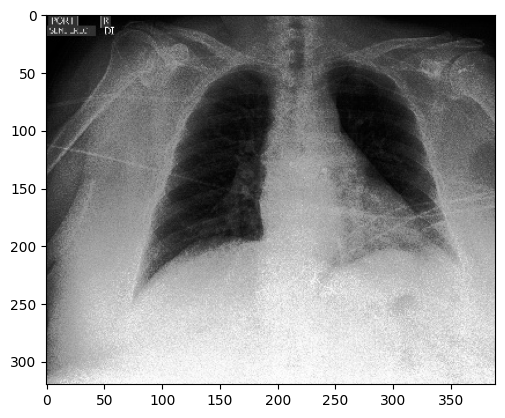

In [7]:
plt.imshow(img,cmap='gray')
plt.show()

In [8]:
demographic_data = pd.read_csv('..\\..\datasets\CheXpert-v1.0-small\demographics_CXP.csv')
demographic_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sutariya\AppData\Local\Temp\ipykernel_14140\1595071097.py:1: SyntaxWarning: invalid escape sequence '\d'
  demographic_data = pd.read_csv('..\\..\datasets\CheXpert-v1.0-small\demographics_CXP.csv')


,subject_id,race,ethnicity,insurance_type
0,42142,White,Non-Hispanic/Non-Latino,Private Insurance
1,4528,White,Non-Hispanic/Non-Latino,Private Insurance
2,55652,White,Non-Hispanic/Non-Latino,Medicare
3,53157,White,Non-Hispanic/Non-Latino,Medicare
4,11162,Asian,Non-Hispanic/Non-Latino,Medicare


In [9]:
training_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [10]:
path = training_data['Path']

In [11]:
patientid = []
for i in path:
     id = i.split(sep='/')[2]
     id = id.replace("patient", "")
     patientid.append(float(id))

In [12]:
patient = pd.DataFrame(patientid,columns=['patient_id'])

In [13]:
patient['patient_id'].nunique()

64540

In [14]:
demographic_data.nunique()

subject_id        64725
race                  8
ethnicity             4
insurance_type        5
dtype: int64

In [15]:
training_data['subject_id'] = patient['patient_id']

In [16]:
training_data.drop_duplicates(subset=['subject_id'], inplace=True, keep='first')
training_data

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,subject_id
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,2.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,4.0
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223407,CheXpert-v1.0-small/train/patient64536/study2/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,64536.0
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,64537.0
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64538.0
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,64539.0


In [17]:
training_data = training_data.reset_index(drop=True)


In [18]:
training_data

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,subject_id
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,2.0
2,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3.0
3,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,4.0
4,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64535,CheXpert-v1.0-small/train/patient64536/study2/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,64536.0
64536,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,64537.0
64537,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64538.0
64538,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,64539.0


In [19]:
training_data_merge = training_data.merge(demographic_data, on='subject_id')

In [20]:
training_data_merge

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,subject_id,race,ethnicity,insurance_type
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,1.0,1.0,Other,Non-Hispanic/Non-Latino,Medicare
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,1.0,NaN,2.0,White,Non-Hispanic/Non-Latino,Unknown
2,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,3.0,White,Non-Hispanic/Non-Latino,Private Insurance
3,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,4.0,Black,Non-Hispanic/Non-Latino,Medicaid
4,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,1.0,5.0,White,Non-Hispanic/Non-Latino,Private Insurance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64520,CheXpert-v1.0-small/train/patient64536/study2/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,64536.0,Other,Hispanic/Latino,Unknown
64521,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,-1.0,0.0,1.0,NaN,NaN,NaN,64537.0,Black,Non-Hispanic/Non-Latino,Private Insurance
64522,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64538.0,White,Non-Hispanic/Non-Latino,Private Insurance
64523,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,1.0,0.0,NaN,NaN,NaN,0.0,64539.0,White,Non-Hispanic/Non-Latino,Private Insurance


In [21]:
training_data_merge = training_data_merge[training_data_merge['race'].isin(training_data_merge['race'].value_counts()[:5].index)]

In [22]:
training_data_merge['race'].value_counts()

race
White      36461
Other       9418
Unknown     7267
Asian       7086
Black       3121
Name: count, dtype: int64

In [23]:
training_data_merge = pd.get_dummies(training_data_merge, columns= ['race'],dtype=float)

In [24]:
training_data_merge.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'subject_id', 'ethnicity', 'insurance_type',
       'race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White'],
      dtype='object')

In [127]:
training_data_merge

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Fracture,Support Devices,subject_id,ethnicity,insurance_type,race_Asian,race_Black,race_Other,race_Unknown,race_White
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,Non-Hispanic/Non-Latino,Medicare,0.0,0.0,1.0,0.0,0.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,1.0,NaN,2.0,Non-Hispanic/Non-Latino,Unknown,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,Non-Hispanic/Non-Latino,Private Insurance,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,NaN,NaN,4.0,Non-Hispanic/Non-Latino,Medicaid,0.0,1.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,...,NaN,1.0,5.0,Non-Hispanic/Non-Latino,Private Insurance,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64520,CheXpert-v1.0-small/train/patient64536/study2/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64536.0,Hispanic/Latino,Unknown,0.0,0.0,1.0,0.0,0.0
64521,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,NaN,NaN,64537.0,Non-Hispanic/Non-Latino,Private Insurance,0.0,1.0,0.0,0.0,0.0
64522,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64538.0,Non-Hispanic/Non-Latino,Private Insurance,0.0,0.0,0.0,0.0,1.0
64523,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,NaN,0.0,64539.0,Non-Hispanic/Non-Latino,Private Insurance,0.0,0.0,0.0,0.0,1.0


In [26]:
no_finding_training_data = training_data_merge.drop(columns = ['Enlarged Cardiomediastinum',
                                                       'Cardiomegaly',
                                                       'Lung Opacity',
                                                       'Lung Lesion',
                                                       'Edema',
                                                       'Consolidation',
                                                       'Pneumonia',
                                                       'Atelectasis',
                                                       'Pneumothorax',
                                                       'Pleural Effusion',
                                                       'Pleural Other',
                                                       'Fracture',
                                                       'Support Devices'])

In [27]:
no_finding_training_data.isna().sum()

Path                   0
Sex                    0
Age                    0
Frontal/Lateral        0
AP/PA                261
No Finding         53514
subject_id             0
ethnicity              0
insurance_type         0
race_Asian             0
race_Black             0
race_Other             0
race_Unknown           0
race_White             0
dtype: int64

In [28]:
no_finding_training_data['No Finding'].fillna(value=0,inplace=True)

C:\Users\sutariya\AppData\Local\Temp\ipykernel_14140\1734456536.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  no_finding_training_data['No Finding'].fillna(value=0,inplace=True)


In [29]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx] / 255.0
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label


In [30]:
data_images = []
for path in no_finding_training_data['Path']:
     full_path = '../../datasets' + '/' + str(path)
     img = read_image(full_path)
     data_images.append(img)

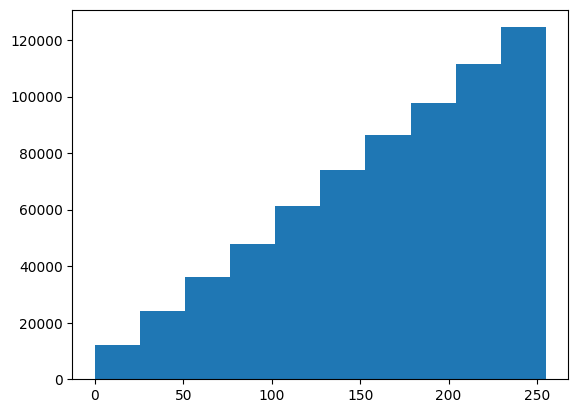

In [35]:
plt.hist(data_images[0].ravel(), cumulative=True)
plt.show()

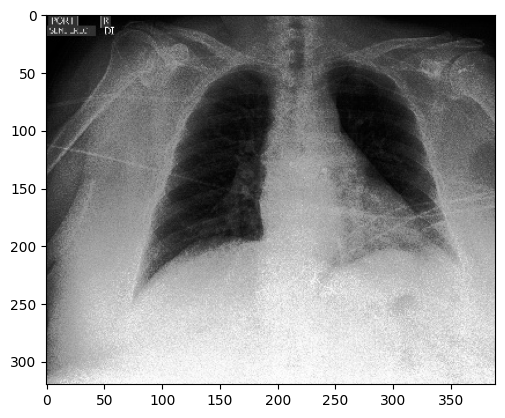

In [32]:
plt.imshow(data_images[0].squeeze(0), cmap='gray')
plt.show()

In [44]:
np.uint8(data_images[0]).shape

(1, 320, 389)

In [102]:
reference_img = read_image('../../datasets/reference_img.jpg')

In [103]:
resize_transform = transforms.Compose([
    transforms.Resize((256, 256))
])

resized_img = np.uint8(resize_transform(reference_img).squeeze(0))

In [120]:
img = np.uint8(resize_transform(data_images[-7]).squeeze(0))

In [121]:
matched = exposure.match_histograms(img, resized_img)

In [122]:
equalized_img = exposure.equalize_hist(img)

In [123]:
equalized_img.max(), equalized_img.min()

(np.float64(1.0), np.float64(0.0007476806640625))

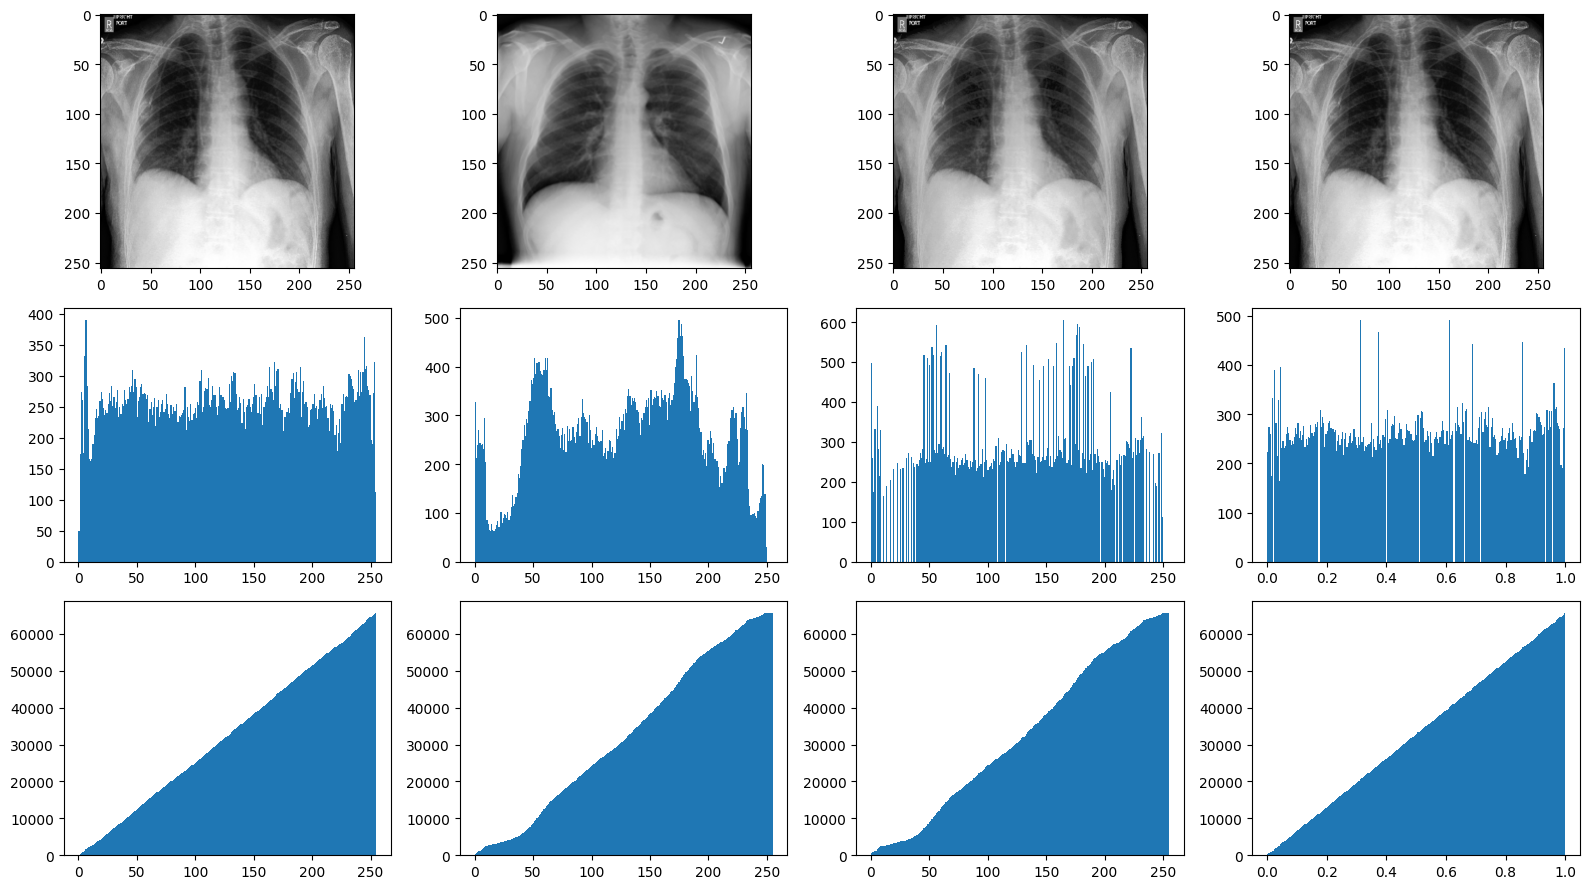

In [124]:
fig, ax = plt.subplots(3, 4, figsize=(16, 9))

ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(resized_img, cmap='gray')
ax[0,2].imshow(matched, cmap='gray')
ax[0,3].imshow(equalized_img, cmap='gray')

ax[1,0].hist(img.ravel(),bins=256,range=(0,255))
ax[1,1].hist(resized_img.ravel(),bins=256,range=(0,255))
ax[1,2].hist(matched.ravel(),bins=256,range=(0,255))
ax[1,3].hist(equalized_img.ravel(),bins=256,range=(0,1))


ax[2,0].hist(img.ravel(),bins=256,range=(0,255), cumulative=True)
ax[2,1].hist(resized_img.ravel(),bins=256,range=(0,255), cumulative=True)
ax[2,2].hist(matched.ravel(),bins=256,range=(0,255), cumulative=True)
ax[2,3].hist(equalized_img.ravel(),bins=256,range=(0,1), cumulative=True)

plt.tight_layout()
plt.show()



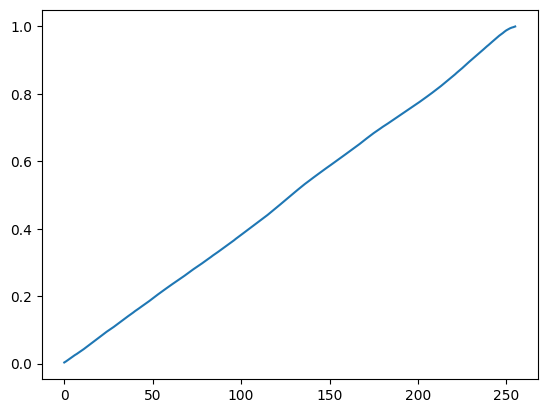

In [147]:
img_cdf, bins = exposure.cumulative_distribution(np.uint8(data_images[0]),255)
plt.plot(bins, img_cdf)
plt.show()

In [125]:
training_data_merge = training_data_merge[training_data_merge['race'].isin(training_data_merge['race'].value_counts()[:5].index)]
training_data_merge = pd.get_dummies(training_data_merge, columns=['race'], drop_first=True)

KeyError: 'race'

In [126]:
data_labels = no_finding_training_data[['race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White']].values
data_labels = torch.tensor(data_labels, dtype=torch.float32)

In [43]:
labels = data_labels.argmax(dim=1) 
labels.shape


torch.Size([63353])

In [70]:
labels.size(0)

63353

In [61]:
torch.max(data_labels, dim=1)

torch.return_types.max(
values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
indices=tensor([2, 4, 4,  ..., 4, 4, 3]))

In [104]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

In [105]:
dataset = MyDataset(data_images,labels,transform)

In [106]:
train_size = int(0.7 * len(dataset)) 
val_size = int(0.10 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

In [107]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [108]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [109]:
for label, img in train_loader:
     print(label.shape, img.shape)
     break

torch.Size([64, 1, 128, 128]) torch.Size([64])


In [100]:
model = torchvision.models.densenet121(weights=None)

In [101]:
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier = nn.Linear(in_features=1024, out_features=5)

In [102]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [86]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

In [91]:
def train_binary_classifier(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=None):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels.float().view(-1, 1).to(device))
        
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float().to(device)
            correct += (predicted == labels.view(-1, 1)).sum().item()
            total += labels.size(0)
            
            train_loop.set_postfix(loss=loss.item(), acc=correct / total)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs).to(device)
                loss = criterion(outputs, labels.float().view(-1, 1).to(device))

                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float().to(device)
                val_correct += (predicted == labels.view(-1, 1)).sum().item()
                val_total += labels.size(0)
                
                val_loop.set_postfix(loss=loss.item(), acc=val_correct / val_total)
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


In [92]:
train_binary_classifier(model,train_loader,val_loader,loss,optimiser,num_epochs=10)

ValueError: Expected input batch_size (64) to match target batch_size (320).

In [55]:
torch.save(model.state_dict(), 'no_finding_model_weights.pth')

In [ ]:
new_race_model = torchvision.models.densenet121(weights=None)

In [110]:
import torch
from tqdm import tqdm

def train_multiclass_classifier(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Labels are class indices
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar
            train_loop.set_postfix(loss=loss.item(), acc=correct / total)
        
        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)  # Get predicted class indices
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                
                # Update progress bar
                val_loop.set_postfix(loss=loss.item(), acc=val_correct / val_total)
        
        # Calculate validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("Training complete.")

In [111]:
train_multiclass_classifier(model, train_loader, val_loader, loss, optimiser, num_epochs=10, device=None)

Epoch [1/10] Training:   1%|          | 5/693 [00:25<57:45,  5.04s/it, acc=0.153, loss=1.59]  

: 